In [1]:
import datacube
import xarray as xr
import matplotlib.pyplot as plt


### Connect to the datacube

Connect to the datacube so we can access DEA data:

In [2]:
dc = datacube.Datacube(app='Pan_sharpening')


In [3]:
query = {'product': 'ga_ls8c_ard_3',
 'x': (149.11, 149.14),
 'y': (-35.31, -35.29),
 'time': '2018',
 'cloud_cover': [0, 1]}


# Native CRS
md = dc.find_datasets(**query)[0].metadata_doc
output_crs = md['crs']

# For reference, load the same image at 30 m resolution
rgbp_15m = dc.load(measurements=['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_panchromatic'],
                  resolution=(-15, 15),
                  align=(7.5, 7.5),
                  output_crs=output_crs,
                  resampling='bilinear',
                  **query)

# For reference, load the same image at 30 m resolution
rgb_30m = dc.load(measurements=['nbart_red', 'nbart_green', 'nbart_blue'],
                  resolution=(-30, 30),
                  align=(15, 15),
                  output_crs=output_crs,
                  **query)

In [4]:
import numpy as np
import skimage.transform
import sklearn.decomposition
from skimage.exposure import match_histograms
from skimage.color import rgb2hsv, hsv2rgb


def _brovey_pansharpen(ds, pan_band):
    """
    Perform the Brovey Transform on a multi-band dataset to generate
    a pansharpened dataset. This function is applied to the entire
    dataset (i.e. all timesteps) at once.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing multi-spectral and panchromatic bands.
    pan_band : str
        Name of the panchromatic band in the dataset.

    Returns
    -------
    ds_pansharpened : xarray.Dataset
        Pansharpened dataset with the same dimensions as the input dataset.
    """

    # Create new dataarrays with and without pan band
    da_nopan = ds.drop(pan_band).to_array()
    da_pan = ds[pan_band]

    # Calculate total
    da_total = da_nopan.mean(dim="variable")

    # Perform Brovey Transform in form of: band / total * panchromatic
    da_pansharpened = da_nopan / da_total * da_pan
    ds_pansharpened = da_pansharpened.to_dataset("variable")

    return ds_pansharpened


def _hsv_timestep(ds_i, pan_band):
    """
    Perform the Hue Saturation Value (HSV) transform on a multi-band
    dataset to generate a pansharpened dataset. This function is
    applied to each timestep in the dataset individually.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing multi-spectral and panchromatic bands.
    pan_band : str
        Name of the panchromatic band in the dataset.

    Returns
    -------
    ds_pansharpened : xarray.Dataset
        Pansharpened dataset with the same dimensions as the input dataset.
    """

    # Convert to an xr.DataArray and move "variable" to end
    da_i = ds_i.to_array().transpose(..., "variable")

    # Create new dataarrays with and without pan band
    da_i_nopan = da_i.drop(pan_band, dim="variable")
    da_i_pan = da_i.sel(variable=pan_band)

    # Convert to HSV colour space
    hsv = rgb2hsv(da_i_nopan)

    # Replace value (lightness) channel with pan band data
    hsv[:, :, 2] = da_i_pan.values

    # Convert back to RGB colour space
    pansharped_array = hsv2rgb(hsv)

    # Add back into original array, reshape and return dataframe
    da_i_nopan[:] = pansharped_array
    ds_pansharpened = da_i_nopan.to_dataset("variable")

    return ds_pansharpened


def _pca_timestep(ds_i, pan_band):
    """
    Perform a Principal component analysis (PCA) transform on a
    multi-band dataset to generate a pansharpened dataset. This
    function is applied to each timestep in the dataset individually.

    Parameters
    ----------
    ds : xarray.Dataset
        Dataset containing multi-spectral and panchromatic bands.
    pan_band : str
        Name of the panchromatic band in the dataset.

    Returns
    -------
    ds_pansharpened : xarray.Dataset
        Pansharpened dataset with the same dimensions as the input dataset.
    """

    # Reshape to 2D by stacking x and y dimensions to
    # prepare it as an input to PCA
    da_2d = ds_i.to_array().stack(pixel=("y", "x")).transpose("pixel", "variable")

    # Create new dataarrays with and without pan band
    da_2d_nopan = da_2d.drop(pan_band, dim="variable")
    da_2d_pan = da_2d.sel(variable=pan_band)

    # Apply PCA transformation
    pca = sklearn.decomposition.PCA()
    pca_array = pca.fit_transform(da_2d_nopan)

    # Match histogram to pan band and apply reverse PCA transform to restore RGBx
    pca_array[:, 0] = match_histograms(da_2d_pan.values, pca_array[:, 0])
    pansharped_array = pca.inverse_transform(pca_array)

    # Add back into original array, reshape and return dataframe
    da_2d_nopan[:] = pansharped_array
    ds_pansharpened = da_2d_nopan.unstack("pixel").to_dataset("variable")

    return ds_pansharpened


def xr_pansharpen(
    ds,
    method,
    pan_band="nbart_panchromatic",
    return_pan=False,
    output_dtype=None,
):

    """
    Apply pan-sharpening to multispectral satellite data with one
    or more timesteps.

    The following pansharpening methods are currently supported:
        - Brovey ("brovey")
        - PCA ("pca")
        - HSV ("hsv")

    Note: Pan-sharpening methods do not necessarily maintain
    the spectral integrity of the input satellite data, and may
    be more suitable for visualisation than quantitative work.
    
    Parameters
    ----------
    ds : xarray.Dataset
        An xarrray dataset containing the three input multispectral
        bands, and a panchromatic band. This dataset should have
        already been resampled to the spatial resolution of the
        panchromatic band (15 m for Landsat). Due to differences in 
        the electromagnetic spectrum covered by the panchromatic band,
        Landsat 8 and 9 data should be supplied with 'blue', 'green', 
        and 'red' multispectral bands, while Landsat 7 should be 
        supplied with 'green', 'red' and 'NIR'.
    method : string
        The pansharpening method to apply to the data. Valid options
        include "brovey", "pca" and "hsv".
    pan_band : string, optional
        The name of the panchromatic band that will be used to
        pan-sharpen the multispectal data.
    return_pan : bool, optional
        Whether to return the panchromatic band in the output dataset.
        Defaults to False.
    output_dtype : string or numpy.dtype, optional
        The dtype used for the output values. Defaults to the input
        dtype of the multispectral bands in `ds`.

    Returns
    -------
    ds_pansharpened : xarray.Dataset
        An xarrray dataset containing the three pan-sharped input
        multispectral bands, and (optionally) the panchromatic band.
    """

    # Define dict linking functions to each method
    method_dict = {
        "brovey": _brovey_pansharpen,
        "pca": _pca_timestep,
        "hsv": _hsv_timestep,
    }

    # If Brovey pansharpening is specified, apply to
    # entire `xr.Dataset` in one go
    if method == "brovey":
        print(f"Applying {method.capitalize()} pansharpening")
        ds_pansharpened = method_dict[method](ds, pan_band=pan_band)

    # Otherwise, apply PCA or HSV pansharpening to each
    # timestep in the `xr.Dataset` using `.apply`
    elif method in ("pca", "hsv"):

        # Apply pansharpening to all timesteps in data
        if "time" in ds.dims:
            print(f"Applying {method.upper()} pansharpening to each timestep")
            ds_pansharpened = ds.groupby("time").apply(
                method_dict[method], pan_band=pan_band
            )
        else:
            print(f"Applying {method.upper()} pansharpening")
            ds_pansharpened = method_dict[method](ds, pan_band=pan_band)
    
    else:
        raise ValueError(
            f"Unsupported value '{method}' passed to `method`. Please "
            "provide either 'brovey', 'pca', or 'hsv'."
        )

    # Optionally insert pan band into dataset
    if return_pan:
        ds_pansharpened[pan_band] = ds[pan_band]

    # Return data in original or requested dtype
    return ds_pansharpened.astype(
        ds.to_array().dtype if output_dtype is None else output_dtype
    )



## Compare outputs

For comparison, plot the 30 m resolution unsharpened data first:

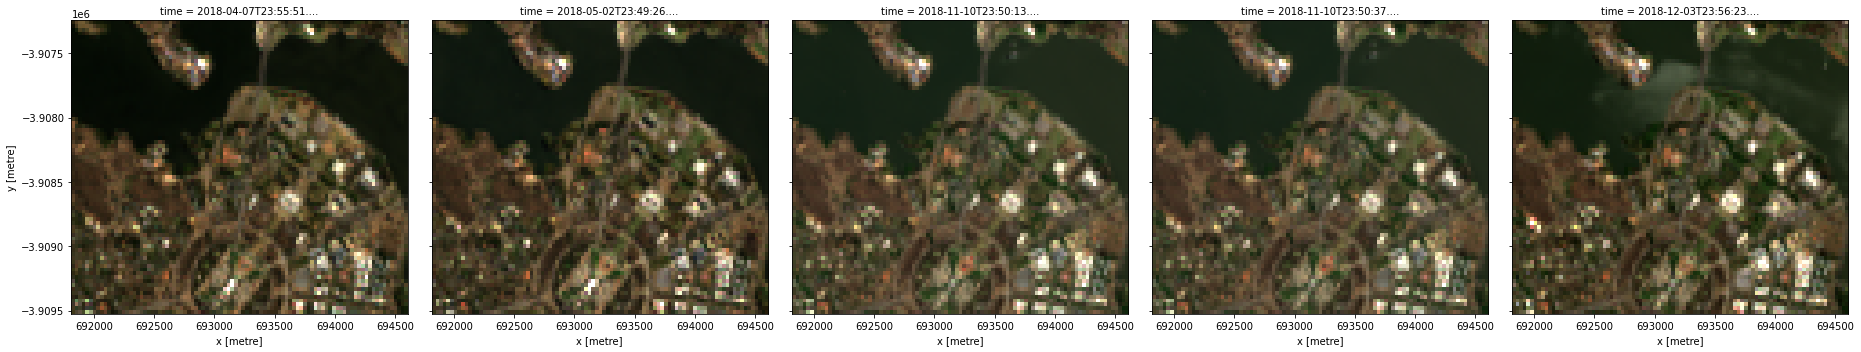

In [5]:
rgb_30m.to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=2500, size=5)

Plot pansharpened data:

Applying HSV pansharpening to each timestep


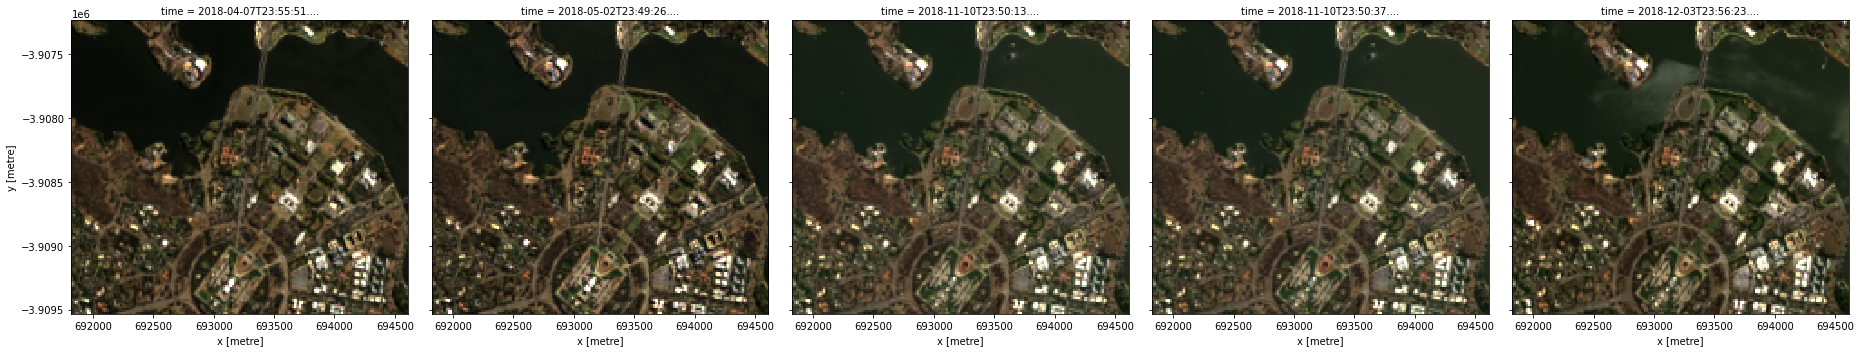

In [6]:
ds_pansharpened_hsv = xr_pansharpen(ds=rgbp_15m, method="hsv")
ds_pansharpened_hsv.to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=2500, size=5)

Applying Brovey pansharpening


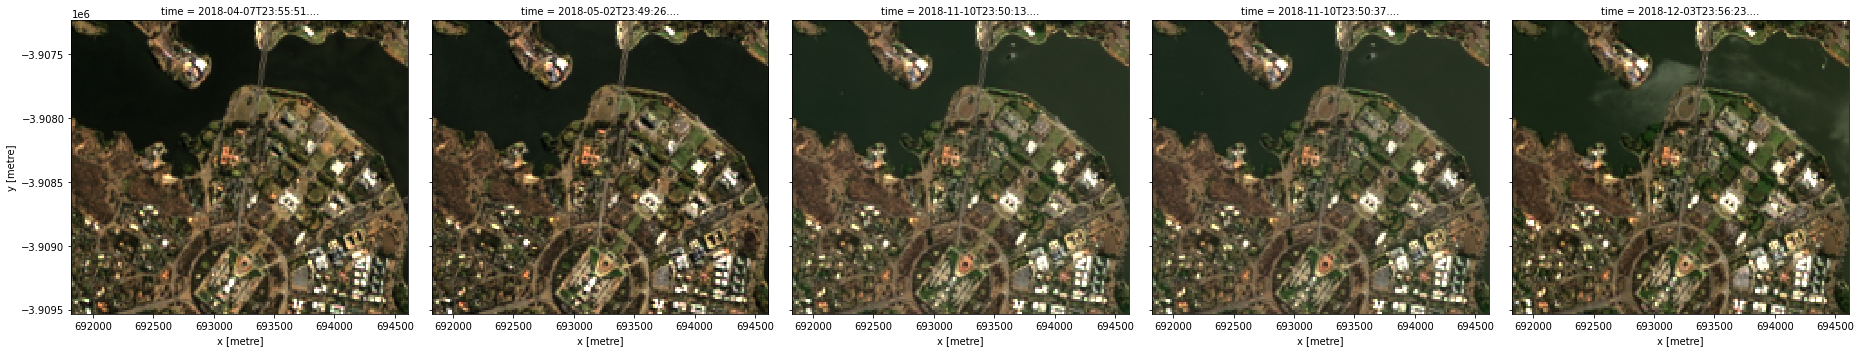

In [7]:
ds_pansharpened_brovey = xr_pansharpen(ds=rgbp_15m, method="brovey")
ds_pansharpened_brovey.to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=2500, size=5)

Applying PCA pansharpening to each timestep


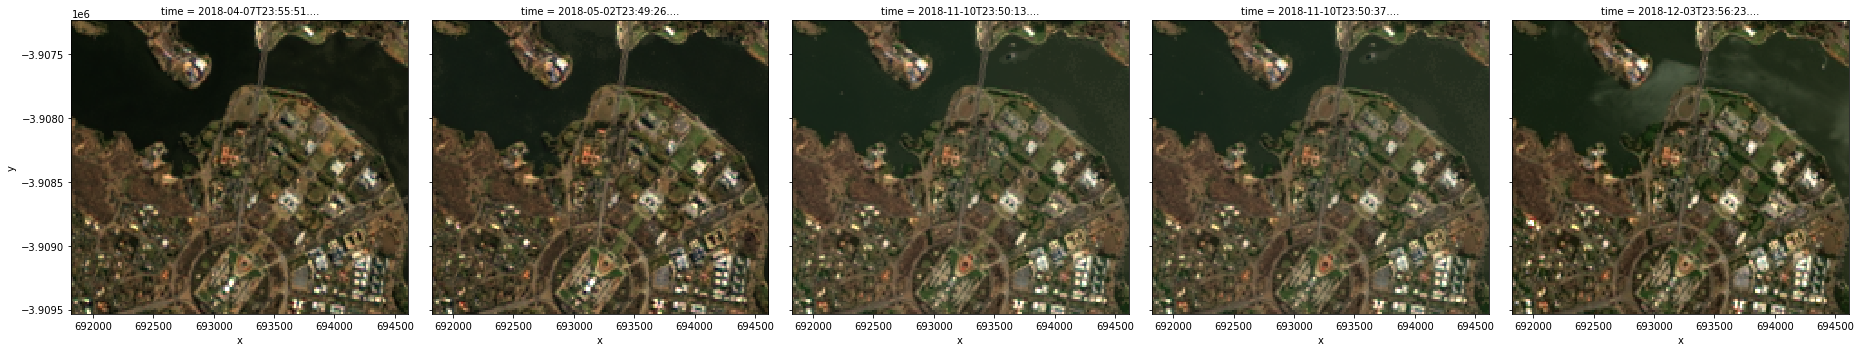

In [8]:
ds_pansharpened_pca = xr_pansharpen(ds=rgbp_15m, method="pca")
ds_pansharpened_pca.to_array().plot.imshow(col='time', col_wrap=5, vmin=0, vmax=2500, size=5)

### Differences between pansharpening methods

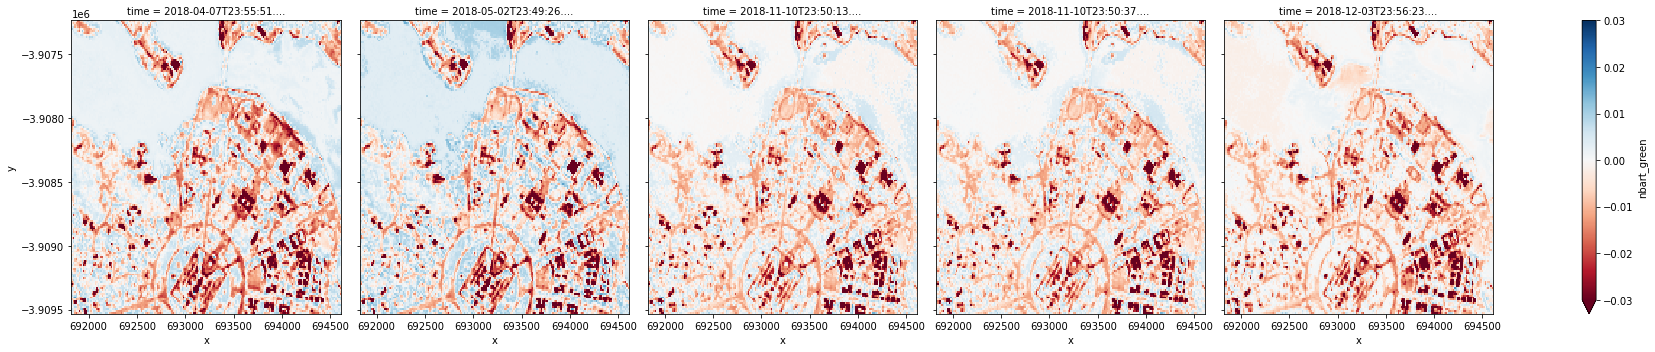

In [9]:
(((ds_pansharpened_pca - ds_pansharpened_brovey).nbart_green) / 10000.0 ).plot(col='time', col_wrap=5, vmin=-0.03, vmax=0.03, cmap='RdBu', size=5)

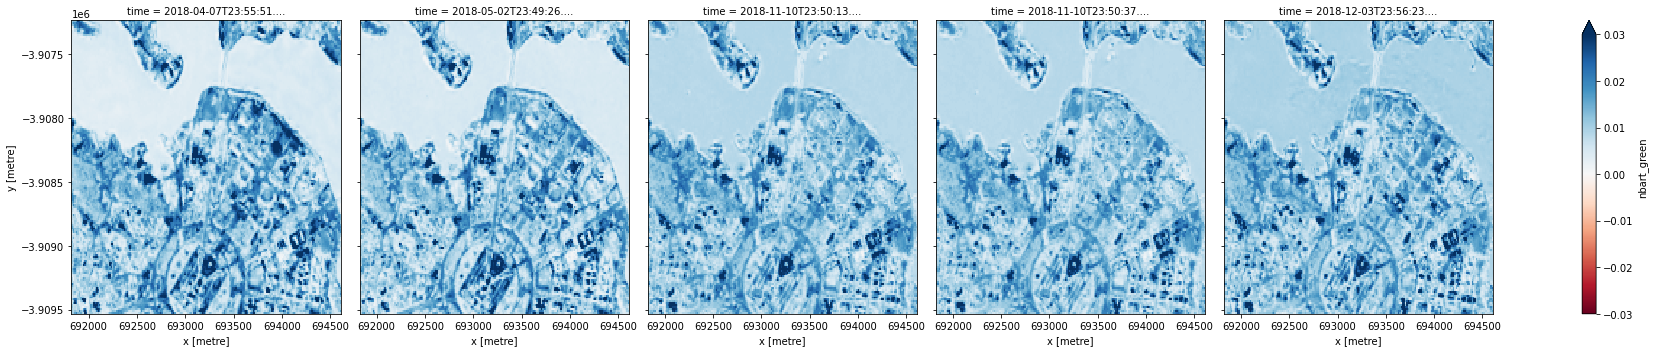

In [10]:
(((ds_pansharpened_brovey - ds_pansharpened_hsv).nbart_green) / 10000.0 ).plot(col='time', col_wrap=5, vmin=-0.03, vmax=0.03, cmap='RdBu', size=5)

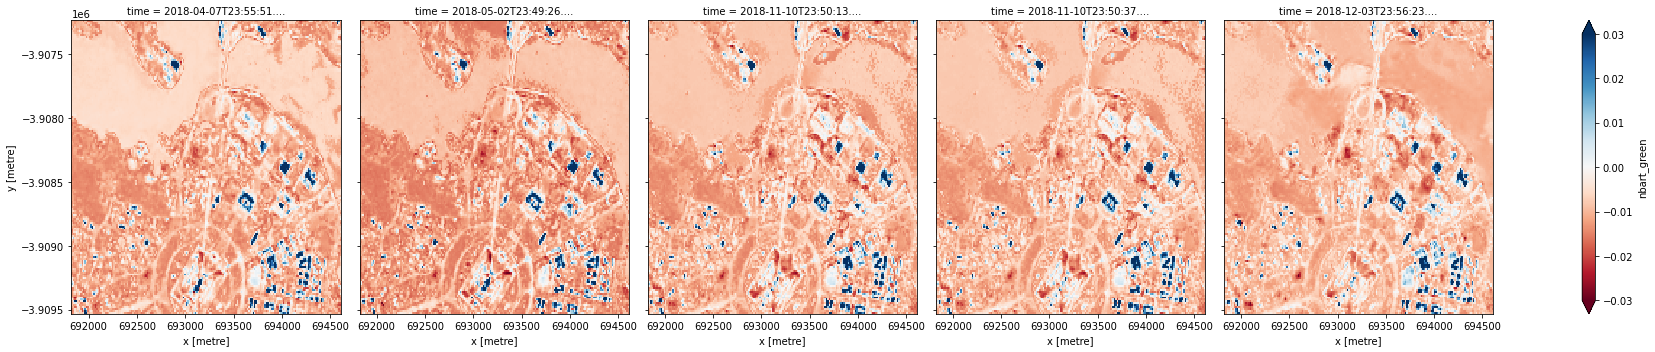

In [11]:
(((ds_pansharpened_hsv - ds_pansharpened_pca).nbart_green) / 10000.0 ).plot(col='time', col_wrap=5, vmin=-0.03, vmax=0.03, cmap='RdBu', size=5)